<a href="https://colab.research.google.com/github/Cehiim/TeoriaDosGrafos/blob/main/Projeto/grafos_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informações gerais

## Integrantes
* Cesar Hideki Imai - 10402758
* João Victor Dallapé Madeira - 10400725
* David Varão Lima Bentes Pessoa - 10402647

# Setup

## Integração dos pacotes

O pacote `vectordb2` é usado para armazenar e recuperar textos usando técnicas de *chunking* (segmentação de texto), *embedding* (conversão de texto para vetores numéricos) e busca vetorial.

In [133]:
%pip install vectordb2

O pacote requests pode ser usado para recuperar o arquivo por meio de requisição em HTTP (esse pacote é opcional).

In [134]:
%pip install requests

O pacote `networkx` é usado para a criação, manipulação e representação de grafos.

In [135]:
%pip install networkx

Importação das bibliotecas

In [136]:
from vectordb import Memory
import requests
import networkx as nx
import matplotlib.pyplot as plt # Será usado para apresentação visual do grafo
import os # Será usado métodos para limpar o terminal para atualizar a interface em cada iteração do sistema
import time # Será usado método de espera para atualizar a interface gradualmente

## Classe Grafo

In [156]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 13 13:59:10 2023

@author: icalc
"""
class Grafo:
    TAM_MAX_DEFAULT = 100 # qtde de vértices máxima default
    # construtor da classe grafo
    def __init__(self, n=TAM_MAX_DEFAULT):
        self.n = n # número de vértices
        self.m = 0 # número de arestas
        # matriz de adjacência
        self.adj = [[0 for i in range(n)] for j in range(n)]

	# Insere uma aresta no Grafo tal que
	# v é adjacente a w
    def insereA(self, v, w):
        if self.adj[v][w] == 0:
            self.adj[v][w] = 1
            self.m+=1 # atualiza qtd arestas

# remove uma aresta v->w do Grafo
    def removeA(self, v, w):
        if(v == w):
            return
        # testa se temos a aresta
        if self.adj[v][w] == 1:
            self.adj[v][w] = 0
            self.m -= 1  # atualiza qtd arestas

	# Apresenta o Grafo contendo
	# número de vértices, arestas
	# e a matriz de adjacência obtida
    def show(self):
        print(f"\n n: {self.n:2d} ", end="")
        print(f"m: {self.m:2d}\n")
        for i in range(self.n):
            for w in range(self.n):
                if self.adj[i][w] == 1:
                    print(f"Adj[{i:2d},{w:2d}] = 1 ", end="")
                else:
                    print(f"Adj[{i:2d},{w:2d}] = 0 ", end="")
            print("\n")
        print("\nfim da impressao do grafo." )


	# Apresenta o Grafo contendo
	# número de vértices, arestas
	# e a matriz de adjacência obtida
    # Apresentando apenas os valores 0 ou 1
    def showMin(self):
        print(f"\n n: {self.n:2d} ", end="")
        print(f"m: {self.m:2d}\n")
        for i in range(self.n):
            for w in range(self.n):
                if self.adj[i][w] == 1:
                    print(" 1 ", end="")
                else:
                    print(" 0 ", end="")
            print("\n")
        print("\nfim da impressao do grafo." )

    def imprimeGrafo(self):
          G = nx.Graph()
          for i in range(len(self.adj)):
            G.add_edge(str(self.adj[i][0]), str(self.adj[i][1]), weight=self.adj[i][2])
          elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > 0.5]
          esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.5]

          pos = nx.spring_layout(G, seed=7)
          fig, axs = plt.subplots()

          nx.draw_networkx_nodes(G, pos, node_size=700)


          nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
          nx.draw_networkx_edges(
              G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
          )

          nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
          edge_labels = nx.get_edge_attributes(G, "weight")
          nx.draw_networkx_edge_labels(G, pos, edge_labels)

          ax = plt.gca()
          ax.margins(0.08)
          plt.axis("off")
          plt.tight_layout()
          plt.show()

'''
    def imprimeGrafo(self):
        # Criar um grafo dirigido usando a matriz de adjacência
        G = nx.DiGraph()  # Grafo dirigido

        # Adicionar vértices e arestas
        for i in range(self.n):
            for j in range(self.n):
                if self.adj[i][j] == 1:
                    G.add_edge(i, j)

        # Plotar o grafo
        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(G)  # Layout para a posição dos nós
        nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_color='black', arrowstyle='-|>', arrowsize=20)
        plt.title(f"Grafo com {self.n} vértices e {self.m} arestas")
        plt.show()
'''

'\n    def imprimeGrafo(self):\n        # Criar um grafo dirigido usando a matriz de adjacência\n        G = nx.DiGraph()  # Grafo dirigido\n\n        # Adicionar vértices e arestas\n        for i in range(self.n):\n            for j in range(self.n):\n                if self.adj[i][j] == 1:\n                    G.add_edge(i, j)\n\n        # Plotar o grafo\n        plt.figure(figsize=(8, 8))\n        pos = nx.spring_layout(G)  # Layout para a posição dos nós\n        nx.draw(G, pos, with_labels=True, node_color=\'lightblue\', node_size=500, font_size=10, font_color=\'black\', arrowstyle=\'-|>\', arrowsize=20)\n        plt.title(f"Grafo com {self.n} vértices e {self.m} arestas")\n        plt.show()\n'

## Classe GrafoR (Grafo direcionado rotulado)

In [157]:
# Grafo como uma matriz de adjacência rotulado
class GrafoR(Grafo): # Ex 16
# Não bota o init, vai bugar a classe

    def insereA(self, v, w, p):
        if self.adj[v][w] == 0:
            self.adj[v][w] = p
            self.m += 1  # atualiza qtd arestas

    def show(self):
        print(f"\n n: {self.n:2d} ", end="")
        print(f"m: {self.m:2d}\n")
        for i in range(self.n):
            for w in range(self.n):
                print(f"Adj[{i:2d},{w:2d}] = {self.adj[i][w]:.2f} ", end="")
            print("\n")
        print("\nfim da impressao do grafo." )


	# Apresenta o Grafo contendo
	# número de vértices, arestas
	# e a matriz de adjacência obtida
    # Apresentando apenas os valores 0 ou 1
    def showMin(self):
        print(f"\n n: {self.n:2d} ", end="")
        print(f"m: {self.m:2d}\n")
        for i in range(self.n):
            for w in range(self.n):
                print(f" {self.adj[i][w]:.2f} ", end="")
            print("\n")
        print("\nfim da impressao do grafo." )

## Classe Memory

Aqui é utilizado a biblioteca VectorDB para criar uma memória virtual.

```
memoria = Memory(chunking_strategy={"mode": "sliding_window", "window_size": 1, "overlap": 0})
```

- `chunking_strategy` define a estratégia de fragmentação dos dados. No modo "sliding_window", os dados são divididos em *chunks* (pedaços de texto) de tamanho fixo.

- `window_size` define a quantidade de palavras que um *chunk* representa. Neste caso, cada *chunk* representa uma palavra.

- `overlap` define quantos elementos de sobreposição existirão entre os *chunks* adjacentes. Neste caso, não haverá sobreposição já que as palavras usadas não formam frases, logo são independentes uma das outras.

### Método SAVE

O método é usado para fazer o *embedding* de uma palavra e inserir na memória.
```
memoria.save("palavra")
```
* `palavra` é a *string* da palavra desejada para inserir na memória.

### Método SEARCH

O método é usado para fazer o *embedding* de uma palavra para consultar a proximidade com as palavras salvas na memória através da busca vetorial.
```
busca = memoria.search(palavra, top_n=4)
```
* `palavra` é a string da palavra usada para consultar a proximidade com as palavras salvas na memória.
* `top_n` define o número de palavras retornadas da consulta.


### [Referência](https://vectordb.com/)

# Métodos

## 1. Ler dados

### Aquisição dos dados

Os dados do documento são importados e guardados na variável `dados`.

In [139]:
def leArquivoHTTP():
  arquivo = requests.get('https://raw.githubusercontent.com/Cehiim/TeoriaDosGrafos/refs/heads/main/Projeto/teste.txt').text

  lista = arquivo.split() # Distribui cada elemento do arquivo numa lista
  n_palavras = int(lista.pop(0)) # Separa o número de palavras (primeira linha do arquivo)
  vertices = []
  for i in range(n_palavras):
    vertice = {
        "palavra": lista[i],
        "indice": i,
        "proximos": []
    }
    vertices.append(vertice)

  dados = [n_palavras]
  dados.append(vertices)

  return dados

In [140]:
def leArquivo(origem):
  with open(origem, 'r', encoding='utf-8') as arquivo:
    n_palavras = int(arquivo.readline()) # Recupera o número de palavras (primeira linha do arquivo)

    vertices = []
    for i in range(n_palavras):
      vertice = {
          "palavra": arquivo.readline().strip(), # Recupera cada palavra e tira o "\n"
          "indice": i,
          "proximos": []
      }
      vertices.append(vertice)

  dados = [n_palavras]
  dados.append(vertices)

  return dados

In [141]:
d = leArquivoHTTP()
#d = leArquivo("./Projeto/palavras.txt")
print(d)

[8, [{'palavra': 'Ecossistema', 'indice': 0, 'proximos': []}, {'palavra': 'Sustentabilidade', 'indice': 1, 'proximos': []}, {'palavra': 'Biodiversidade', 'indice': 2, 'proximos': []}, {'palavra': 'Reciclagem', 'indice': 3, 'proximos': []}, {'palavra': 'Conservação', 'indice': 4, 'proximos': []}, {'palavra': 'Poluição', 'indice': 5, 'proximos': []}, {'palavra': 'Desmatamento', 'indice': 6, 'proximos': []}, {'palavra': 'Reflorestamento', 'indice': 7, 'proximos': []}]]


### Embedding

Cada palavra é convertida para um vetor numérico e guardada na memória.

In [142]:
def embedding(memoria, n_palavras, vertices): # Método para fazer o embedding e inserção na memória de todas as palavras
  for i in range(n_palavras):
    memoria.save(vertices[i]["palavra"])

### Busca vetorial

Quanto menor é a distância, maior é a proximidade semântica.

In [143]:
def buscaVetorial(memoria, palavra): # Método para retornar os quatro elementos com maior proximidade semântica de uma palavra
  busca = memoria.search(palavra, top_n=4)
  return busca

A palavra mais próxima armazenada na memória é ela mesma, portanto para encontrar as outras três palavras mais próximas foram recuperadas as palavras de índice 1 até 4.

In [144]:
m = Memory(chunking_strategy={"mode": "sliding_window", "window_size": 1, "overlap": 0}) # Memória
n = d[0] # Número de palavras
v = d[1] # Lista de vértices (cada vértice é organizado em palavra, índice e vizinhos próximos)

embedding(m, n, v)

b = buscaVetorial(m, "Biodiversidade")
print(b)
print(f"\n\nBusca: Biodiversidade\n")
for i in range(1,4):
  palavra = b[i]['chunk']
  distancia = b[i]['distance']
  print(f"Palavra: {palavra}\nDistância: {distancia:.2f}\n")

Initiliazing embeddings:  normal
OK.
[{'chunk': 'Biodiversidade', 'metadata': {}, 'distance': 0.0}, {'chunk': 'Sustentabilidade', 'metadata': {}, 'distance': 0.44970125}, {'chunk': 'Ecossistema', 'metadata': {}, 'distance': 0.5811522}, {'chunk': 'Poluição', 'metadata': {}, 'distance': 0.6769276}]


Busca: Biodiversidade

Palavra: Sustentabilidade
Distância: 0.45

Palavra: Ecossistema
Distância: 0.58

Palavra: Poluição
Distância: 0.68



### Integração no grafo

In [158]:
def buscaIndice(n_palavras, vertices, palavra):
  for i in range(n_palavras):
    if(vertices[i]["palavra"] == palavra):
      return vertices[i]["indice"]
  return -1

In [159]:
def buscaPalavra(n_palavras, vertices, indice):
  if(indice >= n_palavras or indice < 0):
    return "[Erro: índice inválido]"
  for i in range(n_palavras):
    if(vertices[i]["indice"] == indice):
      return vertices[i]["palavra"]
  return "[Erro: palavra não encontrada]"

A palavra mais próxima armazenada na memória é ela mesma, portanto para encontrar as outras três palavras mais próximas foram recuperadas as palavras de índice 1 até 4.

In [160]:
def integraGrafo(memoria, n_palavras, vertices):
  grafo = GrafoR(n_palavras) # Cria um grafo rotulado
  for i in range(n_palavras):
    busca = buscaVetorial(memoria, vertices[i]["palavra"])
    proximos = []
    for j in range(1,4):
      palavra = busca[j]['chunk']
      distancia = busca[j]['distance']
      proximo = {
          "vizinho": palavra,
          "indice": buscaIndice(n_palavras, vertices, palavra),
          "distancia": distancia
      }
      proximos.append(proximo)
      grafo.insereA(vertices[i]["indice"], proximo["indice"], proximo["distancia"])
    vertices[i]["proximos"] = proximos
  return grafo

{'palavra': 'Ecossistema', 'indice': 0, 'proximos': [{'vizinho': 'Biodiversidade', 'indice': 2, 'distancia': 0.5811522}, {'vizinho': 'Sustentabilidade', 'indice': 1, 'distancia': 0.59003323}, {'vizinho': 'Reflorestamento', 'indice': 7, 'distancia': 0.7258596}]}

 n:  8 m: 24

 0.00  0.59  0.58  0.00  0.00  0.00  0.00  0.73 

 0.59  0.00  0.45  0.00  0.00  0.00  0.00  0.69 

 0.58  0.45  0.00  0.00  0.00  0.68  0.00  0.00 

 0.80  0.00  0.00  0.00  0.00  0.78  0.00  0.64 

 0.00  0.78  0.00  0.00  0.00  0.78  0.86  0.00 

 0.00  0.00  0.68  0.00  0.00  0.00  0.72  0.65 

 0.00  0.00  0.79  0.00  0.00  0.72  0.00  0.69 

 0.00  0.00  0.00  0.64  0.00  0.65  0.69  0.00 


fim da impressao do grafo.


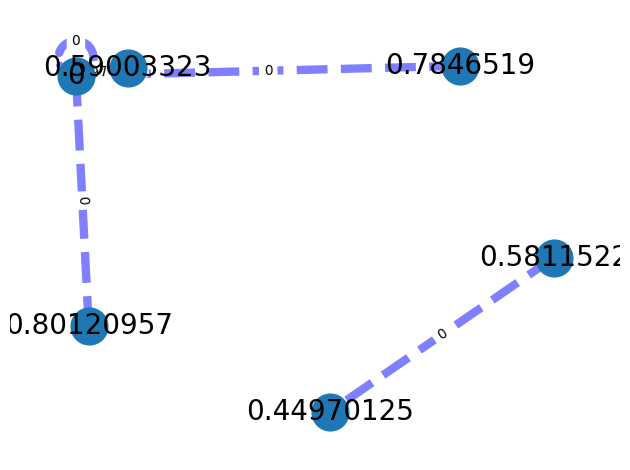

In [161]:
g = integraGrafo(m, n, v)
print(v[0]) # Informações do primeiro elemento da lista de vértices
g.showMin()
g.imprimeGrafo()

## 2. Gravar dados

## 3. Inserir vértice

## 4. Inserir aresta

## 5. Remover vértice

## 6. Remover aresta

## 7. Mostrar conteúdo

## 8. Mostrar grafo

In [ ]:
g.showMin()
g.imprimeGrafo()

## 9. Apresentar conexidade do grafo e o reduzido

# Menu

In [ ]:
memoria = Memory(chunking_strategy={"mode": "sliding_window", "window_size": 1, "overlap": 0})
fim = False

while(fim == False):
    print(
'''
Menu:
    1) Ler dados do arquivo em python
    2) Gravar dados no arquivo grafo.txt
    3) Inserir vértice
    4) Inserir aresta
    5) Remover vértice
    6) Remover aresta
    7) Exibir grafo
    8) Exibir matriz
    9) Apresentar a conexidade do grafo e o reduzido
    10) Encerrar a aplicação
''')
    choice = int(input())
    if choice == 1: # Cria grafo
        dados = leArquivoHTTP()
        #dados = leArquivo("palavras.txt")
        n_palavras = d[0]
        vertices = dados[1]
        embedding(memoria, n_palavras, vertices)
        grafo = integraGrafo(memoria, n_palavras, vertices)
        print("Grafo criado com sucesso!")

    elif choice == 2: # Grava dados no arquivo .txt
        print("Dados salvos com sucesso!")

    elif choice == 3: # Insere vértice
        print("Vértice inserido com sucesso!")

    elif choice == 4: # Insere aresta
        print("Aresta inserida com sucesso!")

    elif choice == 5: # Remove vértice
        print("Vértice removido com sucesso!")

    elif choice == 6: # Remove aresta
        print("Aresta removida com sucesso!")

    elif choice == 7: # Exibe grafo
        grafo.imprimeGrafo()

    elif choice == 8: # Exibe matriz
        grafo.showMin()

    elif choice == 9: # Apresenta a conexidade do grafo e grafo reduzido
        print("oi")

    elif choice == 10: # Encerra
        fim = True
        print("Encerrando programa...")

    else:
        print("Opção inválida.")

    time.sleep(2) # Volta para o menu após 2 segundos

    if os.name == 'nt': # Limpa o terminal
        os.system('cls') # Caso o OS seja Windows
    else:
        os.system('clear') # Caso o OS seja Linux ou MacOS